In [126]:
from nltk import word_tokenize
from string import punctuation
from itertools import chain
from collections import Counter
#pip install opencorpora-tools
import opencorpora
from tqdm.auto import tqdm
import pymorphy2
from scipy.stats import hypergeom
from collections import Counter
import math
from matplotlib import pyplot as plt

In [35]:
corpus = opencorpora.CorpusReader('/media/astromis/Data/Datasets and corpuses/annot.opcorpora.xml')

def doc2tokens(doc):
    tokens = list(chain(*doc.sents()))
    tokens = [x for x in tokens if x not in punctuation]
    return tokens

In [123]:
category_mess = corpus.categories()

In [124]:
category_mess = list(filter(lambda x: "url" not in x, category_mess))
category_mess = list(filter(lambda x: "Время" not in x, category_mess))
category_mess = list(filter(lambda x: "Дата" not in x, category_mess))
category_mess = list(filter(lambda x: "Год" not in x, category_mess))

In [125]:
len(category_mess)

1479

In [127]:
c = Counter()
for cat in tqdm(category_mess):
    docs = corpus.documents(categories=cat)
    c[cat] = len(docs)

  0%|          | 0/1479 [00:00<?, ?it/s]

In [149]:
chaskor = corpus.documents(categories='Тема:ЧасКор:Общество')
wiki = corpus.documents(categories='Тема:ВикиКатегория:Политика')
interview = corpus.documents(categories='Тип:Интервью')

In [150]:
print(len(chaskor), len(wiki), len(interview))

278 93 12


In [174]:
chaskor_tokens = [doc2tokens(x) for x in chaskor]
wiki_tokens = [doc2tokens(x) for x in wiki]
interview_tokens = [doc2tokens(x) for x in interview]

In [430]:
#morph = pymorphy2.MorphAnalyzer()
#chaskor_tokens = [[morph.parse(w)[0].normal_form for w in x]for x in chaskor_tokens]
#wiki_tokens = [[morph.parse(w)[0].normal_form for w in x]for x in wiki_tokens]
#interview_tokens = [[morph.parse(w)[0].normal_form for w in x]for x in interview_tokens]


In [433]:
text_sets = [chaskor_tokens, wiki_tokens, interview_tokens]
text_sets_names = ["chaskor", "wiki", "interview"]

In [434]:
min_tokens = 500 
min(len(list(filter(lambda x: len(x) > min_tokens, y))) for y in text_sets)

12

In [435]:
text_sets = [list(filter(lambda x: len(x) > min_tokens, y)) for y in text_sets]

In [436]:
text_sets = [[tokens[:min_tokens] for tokens in docs[:10]] for docs in text_sets]

In [437]:
len(text_sets[0][8])

500

In [408]:


get_ttr = lambda token_list: len(set(token_list)) / len(token_list)

get_maas = lambda token_list: ( math.log(len(token_list)) - math.log(len(set(token_list))) ) / math.log(len(token_list) ** 2)

def calculate_hd_d(tokens, sample_size=42):
    token_counter = Counter(tokens)
    len_all_tokens = len(tokens)
    proba = []
    for word in token_counter:
        hd = hypergeom(len_all_tokens, token_counter[word], sample_size )
        proba.append(1-hd.pmf(0))
    return sum(proba) / sample_size

In [403]:
def calculate_mtld(tokens, stabilization_point):
    start = 0
    factor_counter = 0
    rest_factor = 0
    curr_ttr = 0
    for i in range(1,len(tokens)):
        curr_ttr = get_ttr(tokens[start:i])
        if  curr_ttr <= stabilization_point:
            factor_counter += 1
            start = i
    #print(f"Factor counter: {factor_counter}")
    if curr_ttr > stabilization_point:
        #print(f"Current ttr: {curr_ttr}")
        rest_factor = (1 - curr_ttr) /(1 - stabilization_point)   
        #print((1 - stabilization_point), (1 - curr_ttr + 1e-6))
    #print(f"Rest factor counter: {rest_factor}")
    overall_factor_counter = factor_counter + rest_factor
    if overall_factor_counter == 0:
        return len(tokens)
    else:
        return len(tokens) / (overall_factor_counter)

def get_mtld(tokens, stabilization_point=0.83):
    forward = calculate_mtld(tokens, stabilization_point)
    backward = calculate_mtld(tokens[::-1], stabilization_point)
    return (forward + backward) /2

In [411]:
metrics = (get_ttr, get_mtld, get_maas, calculate_hd_d)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

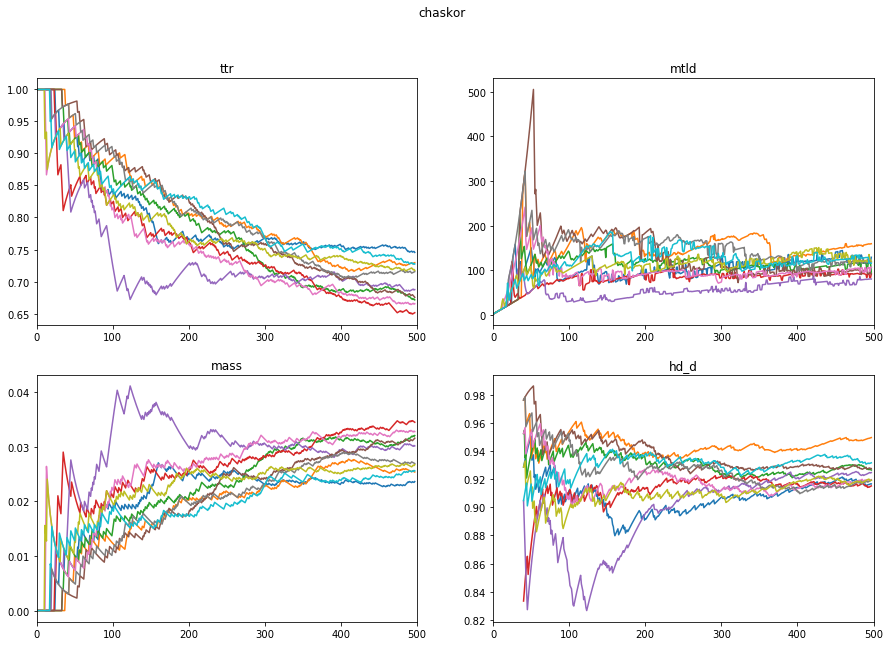

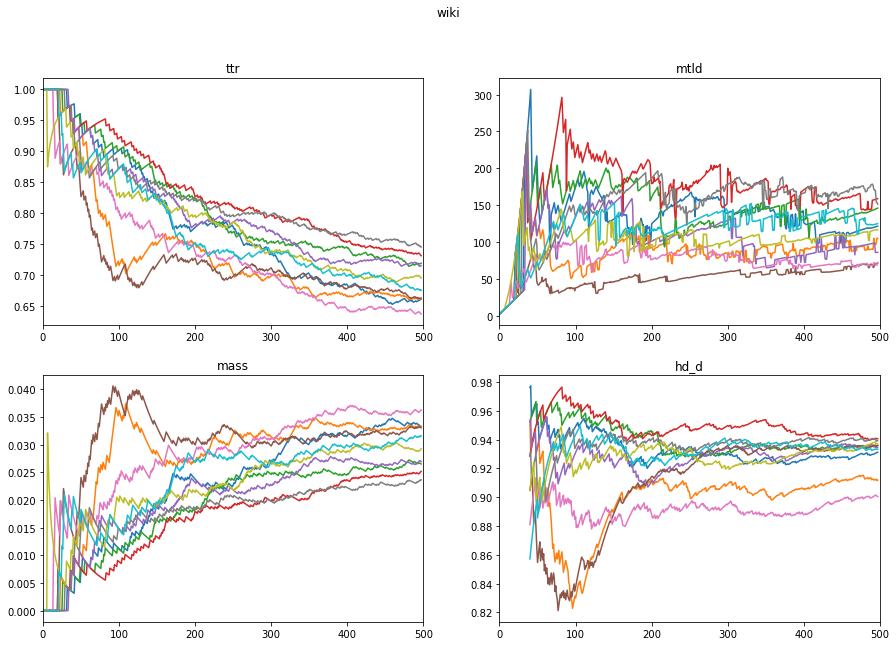

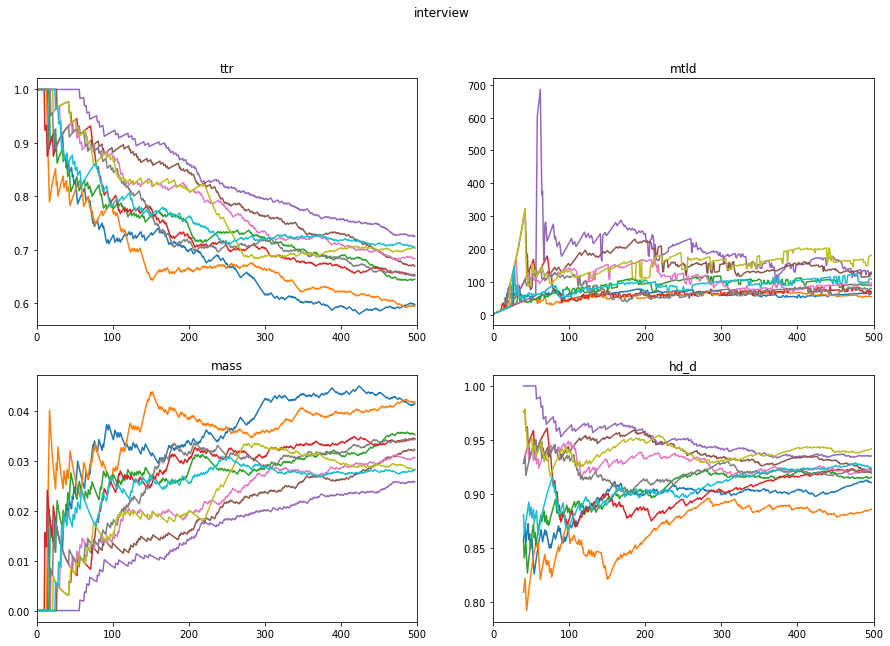

In [423]:

for text_set_name, texts in zip(text_sets_names, text_sets):
    plt.figure(figsize=(15, 10))
    plt.suptitle(text_set_name)
    for i, (metric_name, metric) in enumerate(zip(["ttr", "mtld", "mass", "hd_d"], metrics)):
        whole_ttr = []
        plt.subplot(2, 2, i+1, )
        for tokens in tqdm(texts):
            curr_ttr = []
            for j in range(2, 500):
                curr_ttr.append(metric(tokens[:j]))
            whole_ttr.append(curr_ttr)
        colors = ["red", "green", "blue", "purple", "yellow", "orange", "blue", "black", "gray", "turquoise"]
        for c, ttr in zip(colors, whole_ttr):
            sns.lineplot(range(498), ttr, palette=c)
        plt.xlim(0, 500)
        plt.title(metric_name)
        

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

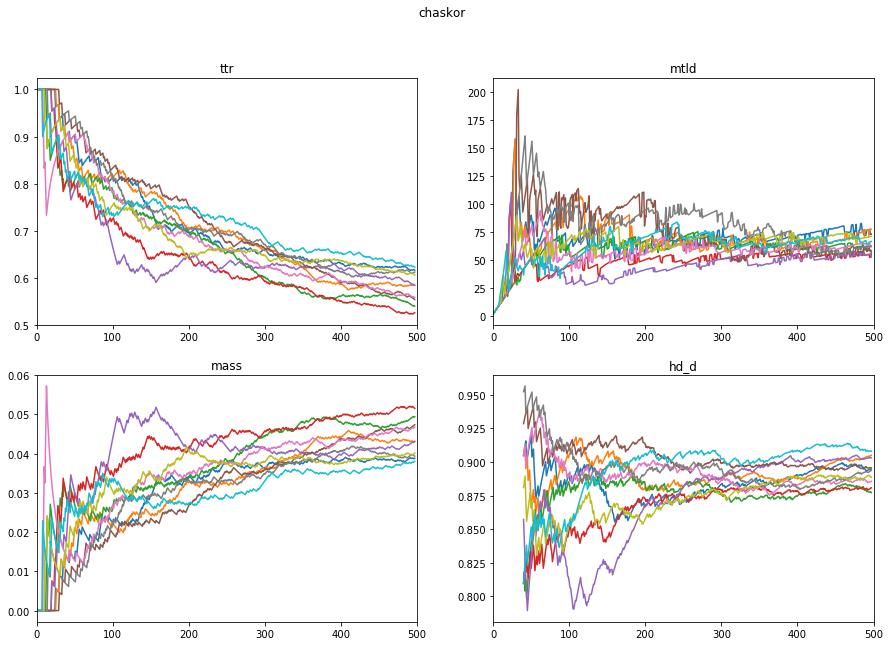

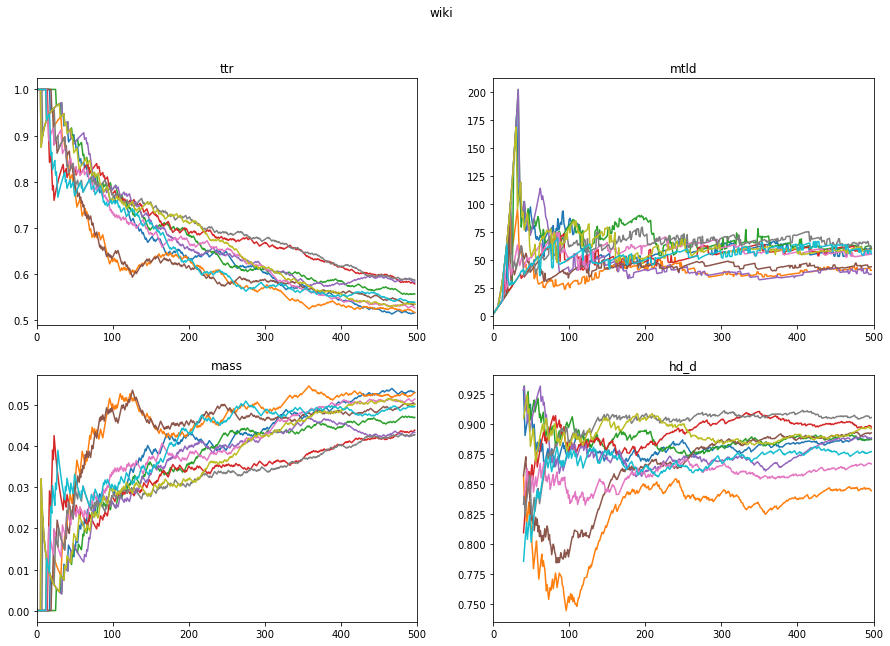

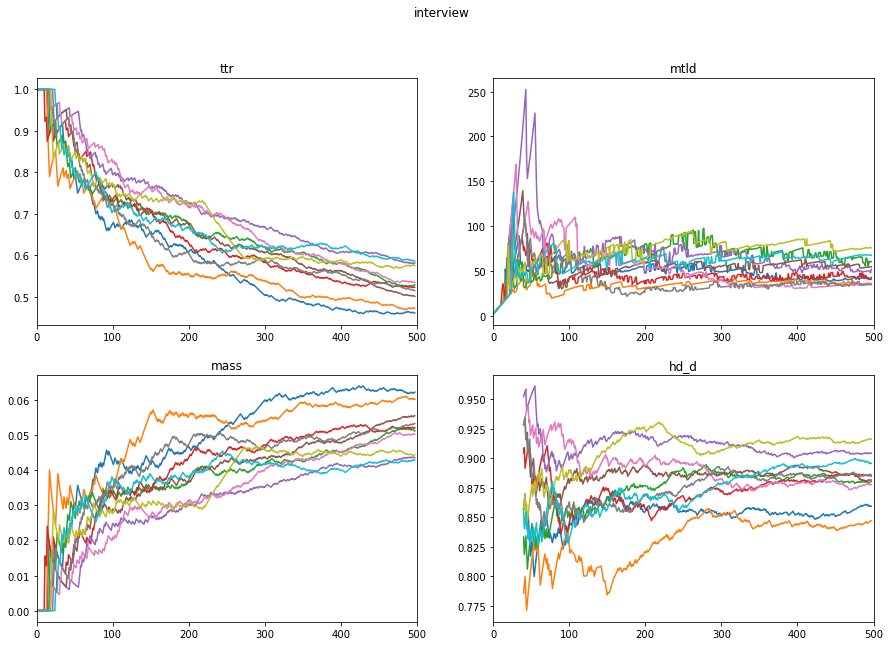

In [438]:

for text_set_name, texts in zip(text_sets_names, text_sets):
    plt.figure(figsize=(15, 10))
    plt.suptitle(text_set_name)
    for i, (metric_name, metric) in enumerate(zip(["ttr", "mtld", "mass", "hd_d"], metrics)):
        whole_ttr = []
        plt.subplot(2, 2, i+1, )
        for tokens in tqdm(texts):
            curr_ttr = []
            for j in range(2, 500):
                curr_ttr.append(metric(tokens[:j]))
            whole_ttr.append(curr_ttr)
        colors = ["red", "green", "blue", "purple", "yellow", "orange", "blue", "black", "gray", "turquoise"]
        for c, ttr in zip(colors, whole_ttr):
            sns.lineplot(range(498), ttr, palette=c)
        plt.xlim(0, 500)
        plt.title(metric_name)
        

In [249]:
import seaborn as sns
from matplotlib import pyplot as plt

(0, 500)

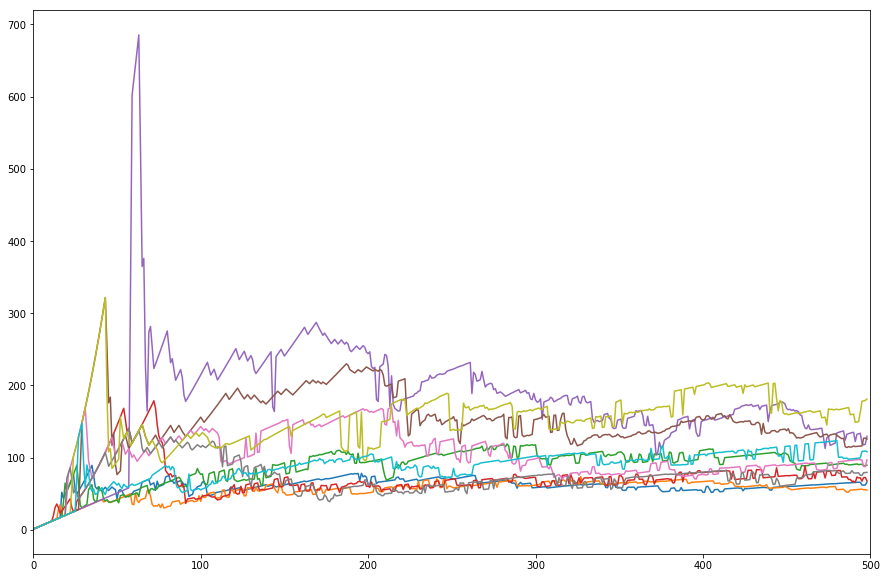

In [374]:
plt.figure(figsize=(15,10))

colors = ["red", "green", "blue", "purple", "yellow", "orange", "blue", "black", "gray", "turquoise"]
for c, ttr in zip(colors, whole_ttr):
    sns.lineplot(range(499), ttr, palette=c)
plt.xlim(0, 500)
#plt.ylim(0, 400)

(220, 500)

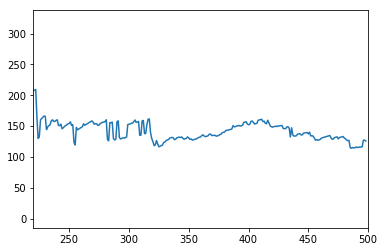

In [391]:
sns.lineplot(range(499), whole_ttr[5], palette=c)
plt.xlim(220, 500)